In [1]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("../iGMRF.jl");
include("../dataGen.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [2]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂;
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;

In [3]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

In [4]:
grid_target[:, :, 2]

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [5]:
grid_target[:, :, 3]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [6]:
nobs = 100;
data = generateData(grid_target, nobs);

In [7]:
data

9-element Vector{Vector{Float64}}:
 [12.240682784141626, 9.621417291612469, 9.754494171763968, 12.271969563649202, 9.010088679836304, 10.37854664173395, 9.953170110473183, 9.445009003021907, 9.742009013625772, 9.570691209584776  …  10.518164573659204, 9.930013357326203, 10.282186137930879, 12.850825190676971, 11.539774471964721, 9.408520146607469, 10.911372616309231, 8.729801983142732, 8.72967686719628, 11.836572621374048]
 [11.273789202970812, 8.631556095806973, 13.163945842014405, 11.344148819126897, 9.546754812779685, 10.288636123061432, 8.323184365488917, 11.519918761572495, 10.633947875839283, 9.701374233994922  …  11.842867771041316, 10.125426468920546, 10.559271503126375, 11.915013128851271, 11.83414170304287, 10.090763718674232, 9.618733796527398, 11.037493453323496, 12.569207209872223, 10.34323657298342]
 [10.84714848560555, 10.09386643901673, 11.374159042999196, 10.054626371286963, 11.072357692987763, 9.28577559547066, 11.744733738776487, 9.621447951938798, 9.092795759344487,

# Modèle 

In [64]:
include("amWG.jl");

niter = 10000;
h = 0.24;
θ₀ = vcat([50], fill(0, m))
F = iGMRF(m₁, m₂, 0)
nchains = 1;

κᵤ, μ = amWG(niter, h, θ₀, Y=data, F=F, nchains=nchains);

warming_size = Int(0.2 * niter);
μSampling = μ[warming_size:end, :, 1];

κ̂ᵤ = mean(κᵤ[warming_size:end]);
μ̂ = mean(μ.value[warming_size:end, :, 1], dims=1);

In [65]:
changerate(μSampling)

             Change Rate
          μ1       0.256
          μ2       0.228
          μ3       0.253
          μ4       0.226
          μ5       0.198
          μ6       0.223
          μ7       0.254
          μ8       0.223
          μ9       0.257
Multivariate       0.892



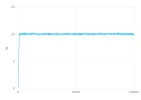

In [66]:
plot(y=μ.value[:, 1, 1], Geom.line)

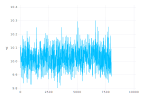

In [67]:
plot(y=μSampling.value[:, 1, 1], Geom.line)

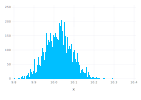

In [68]:
plot(x=μSampling.value[:, 1, 1], Geom.histogram)

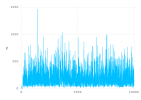

In [69]:
plot(y=κᵤ, Geom.line)

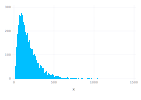

In [70]:
plot(x=κᵤ[warming_size:end], Geom.histogram)

In [71]:
κ̂ᵤ

176.82472645186596

In [72]:
summarystats(μSampling)

      Mean        SD        Naive SE       MCSE        ESS   
μ1 10.023573 0.066447282 0.00074285677 0.0027798124 571.37793
μ2 10.011499 0.057701421 0.00064508119 0.0025964522 493.86969
μ3  9.977300 0.062228966 0.00069569751 0.0026358474 557.37135
μ4 10.036976 0.060486497 0.00067621734 0.0025429620 565.76637
μ5  9.993585 0.049678886 0.00055539212 0.0025568786 377.50565
μ6  9.979748 0.056377325 0.00063027827 0.0026971014 436.93255
μ7  9.986285 0.060798965 0.00067971061 0.0022386311 737.61086
μ8  9.962624 0.055918901 0.00062515325 0.0024751289 510.41288
μ9  9.969931 0.062092670 0.00069417377 0.0023047787 725.80876



In [73]:
reshape(μ̂, m₁, m₂)'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 10.0236   10.0115   9.9773
 10.037     9.99359  9.97975
  9.98629   9.96262  9.96993

In [74]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

Distance entre les deux matrices

In [75]:
norm(reshape(μ̂, m₁, m₂)' .- grid_target[:, :, 1], 2) / m

0.01721916282273679

In [76]:
describe(μSampling)

Iterations = 2000:10000
Thinning interval = 1
Chains = 1
Samples per chain = 8001

Empirical Posterior Estimates:
      Mean        SD        Naive SE       MCSE        ESS   
μ1 10.023573 0.066447282 0.00074285677 0.0027798124 571.37793
μ2 10.011499 0.057701421 0.00064508119 0.0025964522 493.86969
μ3  9.977300 0.062228966 0.00069569751 0.0026358474 557.37135
μ4 10.036976 0.060486497 0.00067621734 0.0025429620 565.76637
μ5  9.993585 0.049678886 0.00055539212 0.0025568786 377.50565
μ6  9.979748 0.056377325 0.00063027827 0.0026971014 436.93255
μ7  9.986285 0.060798965 0.00067971061 0.0022386311 737.61086
μ8  9.962624 0.055918901 0.00062515325 0.0024751289 510.41288
μ9  9.969931 0.062092670 0.00069417377 0.0023047787 725.80876

Quantiles:
     2.5%     25.0%     50.0%      75.0%      97.5%  
μ1 9.896303 9.9758314 10.023722 10.0680610 10.1573729
μ2 9.901677 9.9728751 10.010755 10.0484269 10.1345464
μ3 9.857788 9.9363931  9.977019 10.0166023 10.0960926
μ4 9.926882 9.9946995 10.035566 10.075